### Summary

This notebook presents a typical use of neural network to time series of the EPRI project. A lot of ad hoc modifications are possible, especially at the stage of loading the data, as this is the moment where data is preprocessed and the input and output are determined. When moving the code to an implementable .py file **one should rewrite preprocessing into a pipeline, so that raw data could be fed to the machine.**

Essential parts that have to be edited are preceded by a comment starting with "# TO EDIT". Optional steps are preceded by a comment that ends with "optional."

### Imports

In [24]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import sklearn
from sklearn import metrics
import math
from tensorflow.keras import initializers
import sys

# TO EDIT: replace path with your own path to Aug20_Epri/src/data
# But only needed if you want to use any function from make_dataset.py
sys.path.insert(1, '../src/data')

from make_dataset import remove_clipping_with_flexible_window as rcwfw
from make_dataset import remove_clipping_with_universal_window as rcwuw
from import_data import import_df_from_zip_pkl
import datetime

tf.random.set_seed(42)
np.random.seed(42)

### Loading and preparing the data for the neural network

In [10]:
# Creating datasets of 5-year-long and 3-year-long series
# X being the input, Y being the target
# TO NOTE: 3-year-long time series are picked from the 5-year-long
# as series starting from a 1st of January and ending on a 31st of December
X_3years = np.empty((0, 365*3), float)
X_5years = np.empty((0, 365*5), float)
Y_3years = np.empty((0, 365*3), float)
Y_5years = np.empty((0, 365*5), float)


# List of data to import; feel free to exclude data you don't need by commenting it out
datasets_addresses = [
    '../data/raw/synthetic_soil.zip'
]

for dataset in datasets_addresses:
# Careful here: datasets have different lengths; the range() has to be adjusted and
# might be problematic if you want to load both the 50 basic series and the 150
# soil and weather series 
    for i in range(1, 50):
        print("Loading file #"+str(i)+" from dataset "+dataset.split("/")[0])
        
        df = import_df_from_zip_pkl(dataset, index=i, verbose=True)
        
        # TO EDIT: the preprocessing happens here, to be edited depending on the desired outcome
        # Remove 29th February from time series
        df["date_and_hour"] = [str(i)+"-"+str(j) for i,j in zip(df.index.date, df.index.hour)]
        df = df[df.date_and_hour.str[5:10]!="02-29"]
        power_df = df[df.POA > 1.0].copy()
        power_df["Power_norm"] = (power_df.Power+1) / power_df.POA
        power_df = power_df.groupby(power_df.index.date, as_index=False).Power_norm.median()

        # TO EDIT: adding target to the target list. In this example I'm creating a time series
        # of the degradation with daily resolution, taking for each day the value of the degradation
        # at the first minute of the day.
        Y_5years = np.vstack([
            Y_5years,
            np.array(df[df.index.time == datetime.time(0,0)].Degradation)])
        for j in range(0,3):
            Y_3years = np.vstack([
                Y_3years,
                np.array(df[df.index.time == datetime.time(0,0)].Degradation[:365*3])])
        
        # TO EDIT: adding input to the input list. In this example I add a series of the
        # normalized power Power_norm computed earlier
        X_5years = np.vstack([
            X_5years,
            np.array(power_df.Power_norm)
        ])
        for j in range(0,3):
            X_3years = np.vstack([
                X_3years,
                np.array(power_df.Power_norm[365*j:365*(j+3)])
            ])

print("All done!")

Loading file #1 from dataset ..
time for importing dataframe: 0.67 seconds
Loading file #2 from dataset ..
time for importing dataframe: 0.64 seconds
Loading file #3 from dataset ..
time for importing dataframe: 0.63 seconds
Loading file #4 from dataset ..
time for importing dataframe: 0.67 seconds
Loading file #5 from dataset ..
time for importing dataframe: 0.64 seconds
Loading file #6 from dataset ..
time for importing dataframe: 0.78 seconds
Loading file #7 from dataset ..
time for importing dataframe: 0.68 seconds
Loading file #8 from dataset ..
time for importing dataframe: 0.62 seconds
Loading file #9 from dataset ..
time for importing dataframe: 0.64 seconds
Loading file #10 from dataset ..
time for importing dataframe: 0.63 seconds
Loading file #11 from dataset ..
time for importing dataframe: 0.64 seconds
Loading file #12 from dataset ..
time for importing dataframe: 0.66 seconds
Loading file #13 from dataset ..
time for importing dataframe: 0.68 seconds
Loading file #14 from

In [11]:
# Choose the sample set & target you wanna work on
X = X_3years
Y = Y_3years

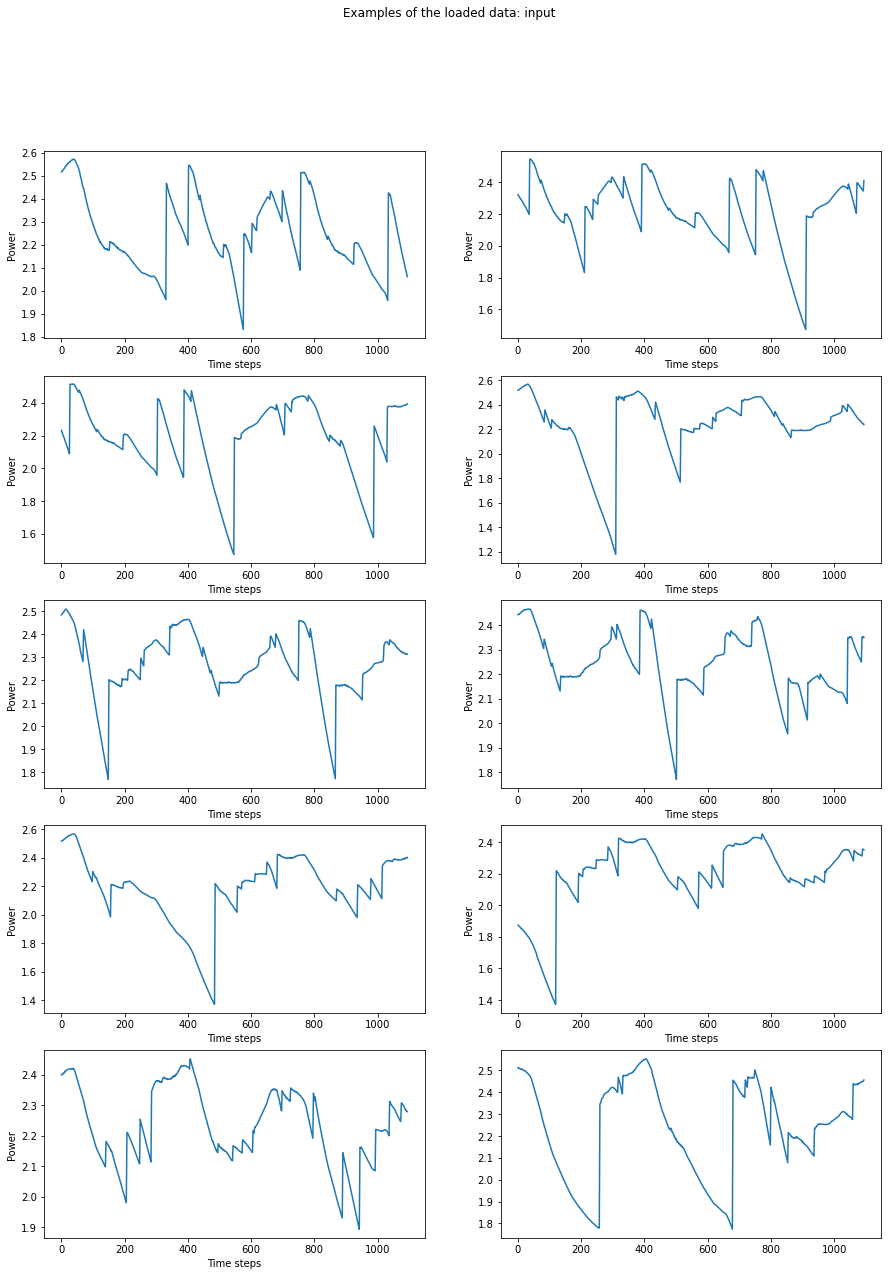

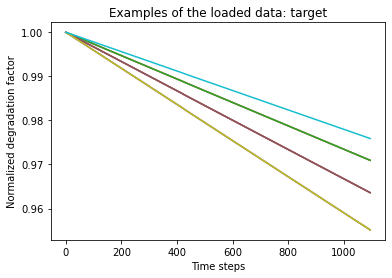

In [12]:
# Check that the data looks like what you expect. Optional but recommended.

plt.figure(figsize=(15,20))
plt.suptitle("Examples of the loaded data: input")
for i in range(0, 10):
    plt.xlabel("Time steps")
    plt.ylabel("Power")
    plt.subplot(5,2,i+1)
    plt.plot(X[i])
plt.show()

plt.figure()
plt.title("Examples of the loaded data: target")
plt.xlabel("Time steps")
plt.ylabel("Normalized degradation factor")
for i in range(0, 10):
    plt.plot(Y[i])
plt.show()

In [13]:
# Dividing the data into training, validation and test sets.

# TO EDIT: if you want a proportion of train/valid/test that
# is different from 70%-15%-15%
train_index = int(len(X)*0.7)
valid_index = int(len(X)*0.85)

X_train = X[:train_index]
X_valid = X[train_index:valid_index]
X_test = X[valid_index:]
Y_train = Y[:train_index]
Y_valid = Y[train_index:valid_index]
Y_test = Y[valid_index:]

# Shuffling the datasets so that, in the case of 3-year-long data,
# mini-batch training doesn't get a streak of samples that were
# all extracted from the same time series.
train_shuffle = np.random.permutation(len(X_train))
valid_shuffle = np.random.permutation(len(X_valid))

X_train = X_train[train_shuffle]
Y_train = Y_train[train_shuffle]
X_valid = X_valid[valid_shuffle]
Y_valid = Y_valid[valid_shuffle]

In [6]:
# For tensorboard and model naming.
run_index = 0

In [23]:
# Early stopping stops training when the loss of the validation set does not beat
# the previous minimum after a certain number of training epochs.
# Number of epochs after which to stop is determined by the parameter
# "patience." Optional, but then remove it from the callbacks (see last line of the cell).
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300)

# To update the name of the model, indicating this is the nth run
run_index = run_index + 1

# TO EDIT: to allow you to distinguish between models you're training. Will be used
# when saving the model and outputing training logs.
model_name = "my_pretty_little_machine"

# Creates and sends log to tensorboard. Optional but useful.
run_logdir = os.path.join(os.curdir, model_name+"_log", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# To save the best model so far during training.
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name+"_run_"+str(run_index)+".h5", save_best_only=True)

time_series_length = len(X[0])

# Creating and compiling the model. Have fun!
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=[time_series_length]))

for i in range(0, 6):
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(time_series_length, activation="elu", kernel_initializer="he_normal"))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(time_series_length, activation="sigmoid", kernel_initializer="he_normal"))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(clipvalue=0.5))

# Training time!
history = model.fit(X_train,
                    Y_train,
                    epochs=100,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
4/4 [==============================] - 1s 212ms/step - loss: 0.2968 - val_loss: 0.4136
Epoch 2/100
4/4 [==============================] - 0s 50ms/step - loss: 0.2718 - val_loss: 0.4402
Epoch 3/100
4/4 [==============================] - 0s 43ms/step - loss: 0.2534 - val_loss: 0.4873
Epoch 4/100
4/4 [==============================] - 0s 52ms/step - loss: 0.2435 - val_loss: 0.4922
Epoch 5/100
4/4 [==============================] - 0s 38ms/step - loss: 0.2344 - val_loss: 0.4782
Epoch 6/100
4/4 [==============================] - 0s 44ms/step - loss: 0.2248 - val_loss: 0.4521
Epoch 7/100
4/4 [==============================] - 0s 36ms/step - loss: 0.2161 - val_loss: 0.4560
Epoch 8/100
4/4 [==============================] - 1s 246ms/step - loss: 0.2035 - val_loss: 0.4056
Epoch 9/100
4/4 [==============================] - 0s 47ms/step - loss: 0.1892 - val_loss: 0.4140
Epoch 10/100
4/4 [==============================] - 2s 445ms/step - loss: 0.1716 - val_loss: 0.3825
Epoch 11/100
4/4

Epoch 81/100
4/4 [==============================] - 3s 756ms/step - loss: 1.4649e-04 - val_loss: 1.9546e-04
Epoch 82/100
4/4 [==============================] - 3s 714ms/step - loss: 1.4278e-04 - val_loss: 1.8498e-04
Epoch 83/100
4/4 [==============================] - 1s 234ms/step - loss: 1.3950e-04 - val_loss: 1.7754e-04
Epoch 84/100
4/4 [==============================] - 3s 710ms/step - loss: 1.3616e-04 - val_loss: 1.6644e-04
Epoch 85/100
4/4 [==============================] - 0s 45ms/step - loss: 1.3352e-04 - val_loss: 1.7090e-04
Epoch 86/100
4/4 [==============================] - 0s 43ms/step - loss: 1.2933e-04 - val_loss: 1.8048e-04
Epoch 87/100
4/4 [==============================] - 0s 52ms/step - loss: 1.2695e-04 - val_loss: 1.9419e-04
Epoch 88/100
4/4 [==============================] - 0s 43ms/step - loss: 1.2375e-04 - val_loss: 1.9470e-04
Epoch 89/100
4/4 [==============================] - 0s 62ms/step - loss: 1.2088e-04 - val_loss: 1.9010e-04
Epoch 90/100
4/4 [===============

In [16]:
# Loading the best parameters and generating a list of predictions.
model = keras.models.load_model(model_name+"_run_"+str(run_index)+".h5")
prediction = model.predict(X_test)

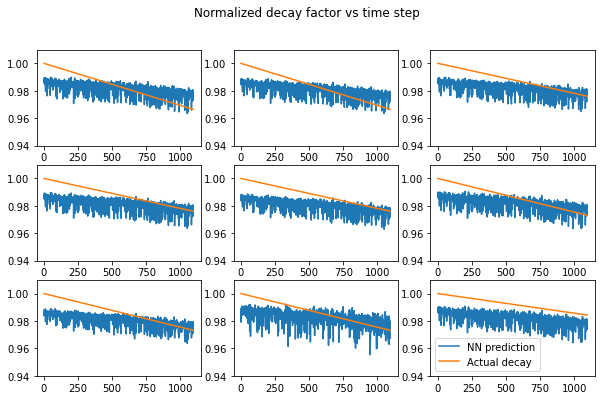

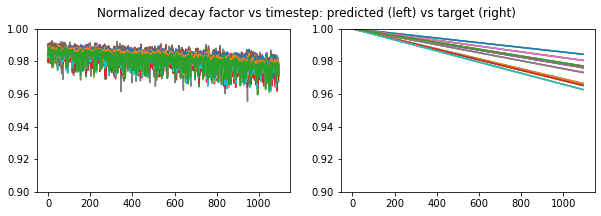

In [17]:
# Visualizing the predictions.
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.suptitle("Normalized decay factor vs time step")
for i in range(0, min(len(prediction), 9)):
    plt.subplot(3,3,i+1)
    plt.ylim(0.94,1.01)
    plt.plot([x for x in prediction[i]])
    plt.plot([x for x in Y_test[i]])
plt.legend(['NN prediction','Actual decay'])
plt.show()

plt.figure(figsize=(10,3))
plt.suptitle("Normalized decay factor vs timestep: predicted (left) vs target (right)")
plt.subplot(1,2,1)
plt.ylim(0.90,1)
for i in range(0,len(prediction)):
    plt.plot(prediction[i])
plt.subplot(1,2,2)
plt.ylim(0.90,1)
for i in range(0,len(Y_test)):
    plt.plot(Y_test[i])
plt.show()

In [21]:
# To convert a decay series into a decay rate.
def extract_yr_degrad(avg_power_decay):
    x = np.array([i/365 for i in range(0,len(avg_power_decay))])
    y = np.array(avg_power_decay)
    return np.polyfit(x,y,1)[0]

# Computing the decay rates from the prediction and target, and
# computing the RMSE between those.
model_pred = []
degradation_rates_test = []
for i in range(0, len(prediction)):
    model_pred.append(extract_yr_degrad(prediction[i, -400:]))
    degradation_rates_test.append(extract_yr_degrad(Y_test[i]))
    
mse = metrics.mean_squared_error(model_pred, degradation_rates_test)
math.sqrt(mse)

0.005520634831114842

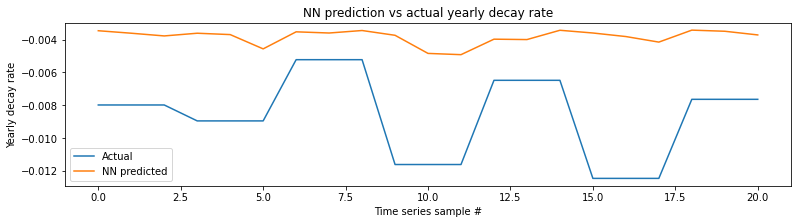

In [19]:
# Plotting decay rate (predicted vs target)

plt.figure(figsize=(13,3))
plt.plot(degradation_rates_test[2:50])
plt.plot(model_pred[2:50])
plt.xlabel("Time series sample #")
plt.ylabel("Yearly decay rate")
plt.title("NN prediction vs actual yearly decay rate")
plt.legend(["Actual","NN predicted"])
plt.show()

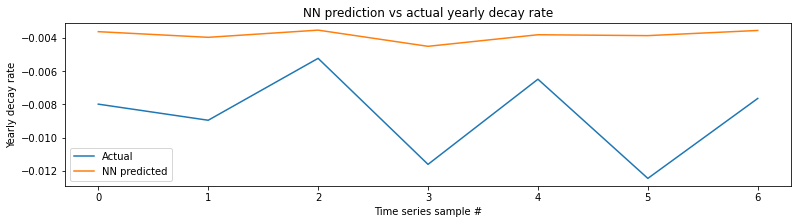

0.0027911025048855584

In [22]:
# In case you used the 3-year-long samples: this takes the mean of three predictions
# of 3-year-long samples extracted from the same 5-year-long time series, thus
# computing an ensemble prediction. Sometimes fares better than simple prediction.

model_pred_aggr = []
degrad_rate_aggr = []
for i in range(len(model_pred)%3,len(model_pred),3):
    degrad_rate_aggr.append(degradation_rates_test[i])
    model_pred_aggr.append(np.mean(model_pred[i:i+3]))
    
plt.figure(figsize=(13,3))
plt.plot(degrad_rate_aggr)
plt.plot(model_pred_aggr)
plt.xlabel("Time series sample #")
plt.ylabel("Yearly decay rate")
plt.title("NN prediction vs actual yearly decay rate")
plt.legend(["Actual","NN predicted"])
plt.show()

mse = metrics.mean_squared_error([-0.01]*len(degrad_rate_aggr), degrad_rate_aggr)
math.sqrt(mse)

### Best models

This section is left empty for you to copy/paste models and preprocessing that works well. Too often did I want to try a modification and ended up editing and then forgetting about the edits of a promising model.